# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">0. Preambule</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">0.1 About this Notebook</h1></span>

<div class="alert alert-block alert-info">
    <font color = "red"></font> The following work uses data from <a href = "https://openproblems.bio/neurips_docs/about/about/"> NeurIPS 2021 Competition</a>, specially <strong>scRNA-seq</strong>. The notebook is quite large, i highly recommend to use the "Table of Contents". All the references are going to be at the end of this work. 
    I'm looking for a remote job to pay my undergraduate studies on <strong>molecular biology</strong>, if you wanna contact me, i leave me email: hiramcoria@gmail.com</div>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">0.2 Installing Libraries</h1></span>

In [1]:
!pip install scanpy
!pip install leidenalg
!pip install scvi-tools
!pip install scikit-misc

     |████████████████████████████████| 2.0 MB 2.0 MB/s 
     |████████████████████████████████| 91 kB 7.1 MB/s 
     |████████████████████████████████| 103 kB 64.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=d62cf837bb30f7da89f3c0e07cd353dca3fa50ccfb619db94515c5c93ee349ef
  Stored in directory: /root/.cache/pip/wheels/68/ca/56/344d532fe53e855ccd6549795d370588ab8123907eecf4cf30
Successfully built sinfo
     |████████████████████████████████| 1.4 MB 2.1 MB/s 
     |████████████████████████████████| 231 kB 1.8 MB/s 
     |████████████████████████████████| 242 kB 22.9 MB/s 
     |████████████████████████████████| 678 kB 36.1 MB/s 
     |████████████████████████████████| 214 kB 53.6 MB/s 
     |████████████████████████████████| 813 kB 35.5 MB/s 
     |████████████████████████████████| 51 kB 5.3 MB/s 
  Created wheel for docrep: filename=docrep-0.3.2-py3-none-any.whl size=19895 sha256=777be55

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">0.3 Loading Libraries</h1></span>

In [2]:
### General ###
import os
import random
import logging
import numpy as np
import pandas as pd

### Single-Cell ###
import scvi
import scanpy as sc
import anndata as ad

### Visualization ###
from colorama import Fore
import matplotlib.pyplot as plt

### PyTorch Ecosystem ###
import torch

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">0.3 Configuration</h1></span>

In [3]:
plt.style.use("bmh")

In [4]:
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

In [5]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(seed)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">1. The Data</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">1.1 Loading Data</h1></span>

A huge advatage of scvi-tools is the fact that it supports the `AnnData` format, which also underlies `Scanpy`. Inside `adata.X` contains the gene expression data

In [6]:
adata_gex = ad.read_h5ad("../input/singlecell-multiomics/multiome_gex_processed_training.h5ad")

In [7]:
print(f"{b_}The GEX data has {r_}{adata_gex.n_obs}{b_} observations and {r_}{adata_gex.n_vars}{b_} features.")

The GEX data has 22463 observations and 13431 features.


Showing what does "var" contains: 

In [8]:
adata_gex.var.head()

gene_ids feature_types  genome
AL627309.5  ENSG00000241860           GEX  GRCh38
LINC01409   ENSG00000237491           GEX  GRCh38
LINC01128   ENSG00000228794           GEX  GRCh38
NOC2L       ENSG00000188976           GEX  GRCh38
KLHL17      ENSG00000187961           GEX  GRCh38

In [9]:
adata_gex.var.feature_types

AL627309.5    GEX
LINC01409     GEX
LINC01128     GEX
NOC2L         GEX
KLHL17        GEX
             ... 
MT-ND5        GEX
MT-ND6        GEX
MT-CYB        GEX
AL592183.1    GEX
AC240274.1    GEX
Name: feature_types, Length: 13431, dtype: category
Categories (1, object): ['GEX']

Showing what does "obs" contains:

In [10]:
adata_gex.obs.head()

n_genes_by_counts  pct_counts_mt  n_counts  n_genes  \
TAGTTGTCACCCTCAC-1-s1d1               1022       1.061008    1508.0     1022   
CTATGGCCATAACGGG-1-s1d1               1081       0.604230    1655.0     1081   
CCGCACACAGGTTAAA-1-s1d1               3304       0.650069    7230.0     3304   
TCATTTGGTAATGGAA-1-s1d1                793       0.812274    1108.0      793   
ACCACATAGGTGTCCA-1-s1d1               1219       1.674770    1851.0     1219   

                         size_factors phase      cell_type  \
TAGTTGTCACCCTCAC-1-s1d1      0.453484     S  Naive CD20+ B   
CTATGGCCATAACGGG-1-s1d1      0.455631   G2M     CD14+ Mono   
CCGCACACAGGTTAAA-1-s1d1      2.435348   G2M         CD8+ T   
TCATTTGGTAATGGAA-1-s1d1      0.347226   G2M         CD8+ T   
ACCACATAGGTGTCCA-1-s1d1      0.534205   G2M     CD16+ Mono   

                         pseudotime_order_GEX batch  
TAGTTGTCACCCTCAC-1-s1d1                   NaN  s1d1  
CTATGGCCATAACGGG-1-s1d1                   NaN  s1d1  
CCGCACACAGGTTAAA-1-s1d1                   NaN  s1d1  
TCATTTGGTAATGGAA-1-s1d1                   NaN  s1d1  
ACCACATAGGTGTCCA-1-s1d1                   NaN  s1d1

How many batchs contains this `AnnData` object:

In [11]:
adata_gex.obs["batch"].nunique()

5

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">1.2 Preprocessing the Data </h1></span>


It is common to remove outliers, and even perform `feature selection` before model fitting. I prefer the Scanpy preprocessing module at this stage but i have a notebook where i show how to use [SCMER](https://www.kaggle.com/hiramcho/scrna-seq-scanpy-scmer-for-feature-selection). Removing genes and cells that are very lowly expressed:

In [12]:
sc.pp.filter_genes(adata_gex, min_counts = 3)
sc.pp.filter_cells(adata_gex, min_counts = 3)

In scRNA-seq analysis, it's popular to normalize the data. There values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (`.raw`)

Note: It's important to keep the count information intact for scvi-tools models.

In [13]:
adata_gex.layers["counts"] = adata_gex.X.copy()

Now we can proceed with common normalization methods

In [14]:
sc.pp.normalize_total(adata_gex, target_sum = 1e4)
sc.pp.log1p(adata_gex)

Storing the normalized values in `.raw` to keep them safe in the event the anndata gets subsetted feature-wise.

In [15]:
adata_gex.raw = adata_gex

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">2. Introdution to scvi-tools</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">2.1 Register the Data with scvi-tools
</h1></span>

Now that we have an AnnData object, we need to alert scvi-tools of all the interesting data in our object. For example, now that we have batches in our AnnData, we can alert the models that we'd like to perform batch correction. Also, because we have the count data in a layer, we can use the `layer` argument.

Normally, we set up the data right before using a model, thus we would call the `setup_anndata` method specific to that model. However, we are not using any particular model here since we are just demonstrating data usage and handling in this tutorial. We will use the SCVI model's `setup_anndata` method here and in what follows for sake of example.

Finally we perform **feature selection**, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform features selection, please refer the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but will be context-dependent.

In [16]:
adata_gex.obs["n_genes"].nunique()

3183

In [17]:
sc.pp.highly_variable_genes(
    adata_gex,
    n_top_genes = 1500,
    subset = True,
    layer = "counts",
    flavor = "seurat_v3",
    batch_key = "cell_type"
)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


Now it's time to run `setup_anndata()`, whoch alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details. 

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender", and "age_group". There are also two continuous covariate we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [18]:
scvi.model.LinearSCVI.setup_anndata(
    adata_gex,
    layer = "counts",
    batch_key = "batch"
)

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Successfully registered anndata object containing 22463 cells, 1500 vars, 5 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/opt/conda/lib/python3.7/site-packages/scvi/data/_anndata.py:316: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  "Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization."


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">2.2 Creating and Training a LDVAE Model </h1></span>

This model replaces the neural networks with linear functions. Therefere, can be compared with *probabilistic PCA* or *factor analysis*. 

In [19]:
model = scvi.model.LinearSCVI(adata_gex)

/opt/conda/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


#### Viewing the scvi-tools data setup

In [20]:
scvi.data.view_anndata_setup(model.adata)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


Anndata setup with scvi-tools version 0.14.5.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 22463 │
│             Vars             │ 1500  │
│            Labels            │   1   │
│           Batches            │   5   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │  adata.layers['counts']   │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    Batch Categories                     
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │    s1d1    │          0          │
│                    │    s1d2    │          1          │
│                    │    s2d1    │          2          │
│                    │    s2d4    │          3          │
│                    │    s3d6    │          4          │
└────────────────────┴────────────┴─────────────────────┘

In [21]:
%%time
model.train()

Epoch 356/356: 100%|██████████| 356/356 [16:54<00:00,  2.85s/it, loss=554, v_num=1]
CPU times: user 16min 48s, sys: 4.82 s, total: 16min 52s
Wall time: 16min 57s


## Saving and loading

In [22]:
#model = scvi.model.SCVI.load("my_model/", adata_gex, use_gpu = True)
#model = scvi.model.SCVI.load("my_model/", adata_gex, use_gpu = True)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">2.3 Obtaining Model Outputs</h1></span>

In [23]:
latent = model.get_latent_representation()

/opt/conda/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy

In [24]:
adata_gex.obsm["X_scVI"] = latent

The `model.get...()` functions default using anndata that was used to initialize he model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion

In [25]:
adata_gex.obs.cell_type

TAGTTGTCACCCTCAC-1-s1d1       Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1          CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1              CD8+ T
TCATTTGGTAATGGAA-1-s1d1              CD8+ T
ACCACATAGGTGTCCA-1-s1d1          CD16+ Mono
                                 ...       
TAGTAAGCAACTAGGG-8-s3d6                 HSC
TGGTCCTTCGGCTAGC-8-s3d6    CD4+ T activated
CGCTTGCGTTGTTGGA-8-s3d6                 pDC
ACCCTCCCAGCCAGTT-8-s3d6              CD8+ T
AGTGAACCATCCCGCT-8-s3d6    CD4+ T activated
Name: cell_type, Length: 22463, dtype: category
Categories (21, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [26]:
denoised = model.get_normalized_expression()
denoised

CDK11B     PLCH2  TNFRSF14-AS1  TNFRSF14      ESPN  \
TAGTTGTCACCCTCAC-1-s1d1  0.000416  0.000012      0.000019  0.000323  0.000035   
CTATGGCCATAACGGG-1-s1d1  0.000634  0.000006      0.000037  0.000636  0.000003   
CCGCACACAGGTTAAA-1-s1d1  0.000469  0.000201      0.000077  0.000810  0.000006   
TCATTTGGTAATGGAA-1-s1d1  0.000555  0.000109      0.000068  0.000479  0.000039   
ACCACATAGGTGTCCA-1-s1d1  0.000670  0.000006      0.000046  0.000813  0.000005   
...                           ...       ...           ...       ...       ...   
TAGTAAGCAACTAGGG-8-s3d6  0.000666  0.000016      0.000072  0.000374  0.000007   
TGGTCCTTCGGCTAGC-8-s3d6  0.000499  0.000064      0.000036  0.000397  0.000005   
CGCTTGCGTTGTTGGA-8-s3d6  0.000585  0.000006      0.000016  0.000141  0.000014   
ACCCTCCCAGCCAGTT-8-s3d6  0.000752  0.000099      0.000099  0.000530  0.000011   
AGTGAACCATCCCGCT-8-s3d6  0.000614  0.000110      0.000058  0.000532  0.000013   

                             H6PD    CLSTN1    TARDBP    AGTRAP      MFN2  \
TAGTTGTCACCCTCAC-1-s1d1  0.000085  0.000479  0.000560  0.000063  0.000240   
CTATGGCCATAACGGG-1-s1d1  0.000189  0.000452  0.000392  0.000499  0.000281   
CCGCACACAGGTTAAA-1-s1d1  0.000277  0.000852  0.000467  0.000269  0.000099   
TCATTTGGTAATGGAA-1-s1d1  0.000136  0.000587  0.000439  0.000203  0.000158   
ACCACATAGGTGTCCA-1-s1d1  0.000187  0.000413  0.000462  0.000585  0.000325   
...                           ...       ...       ...       ...       ...   
TAGTAAGCAACTAGGG-8-s3d6  0.000226  0.000529  0.000712  0.000169  0.000307   
TGGTCCTTCGGCTAGC-8-s3d6  0.000180  0.001152  0.000572  0.000055  0.000185   
CGCTTGCGTTGTTGGA-8-s3d6  0.000083  0.000927  0.000834  0.000044  0.000393   
ACCCTCCCAGCCAGTT-8-s3d6  0.000170  0.001144  0.000668  0.000103  0.000365   
AGTGAACCATCCCGCT-8-s3d6  0.000167  0.000806  0.000632  0.000065  0.000293   

                         ...    MT-ND1    MT-CO1    MT-CO2   MT-ATP8  \
TAGTTGTCACCCTCAC-1-s1d1  ...  0.004043  0.021561  0.010176  0.000325   
CTATGGCCATAACGGG-1-s1d1  ...  0.003132  0.017756  0.008204  0.000357   
CCGCACACAGGTTAAA-1-s1d1  ...  0.003342  0.017642  0.008595  0.000308   
TCATTTGGTAATGGAA-1-s1d1  ...  0.004272  0.018910  0.008940  0.000368   
ACCACATAGGTGTCCA-1-s1d1  ...  0.004888  0.027542  0.013473  0.000506   
...                      ...       ...       ...       ...       ...   
TAGTAAGCAACTAGGG-8-s3d6  ...  0.000122  0.000593  0.000312  0.000156   
TGGTCCTTCGGCTAGC-8-s3d6  ...  0.000042  0.000237  0.000102  0.000054   
CGCTTGCGTTGTTGGA-8-s3d6  ...  0.000070  0.000401  0.000183  0.000098   
ACCCTCCCAGCCAGTT-8-s3d6  ...  0.000121  0.000616  0.000309  0.000161   
AGTGAACCATCCCGCT-8-s3d6  ...  0.000072  0.000397  0.000179  0.000083   

                          MT-ATP6    MT-CO3    MT-ND3    MT-ND4    MT-ND5  \
TAGTTGTCACCCTCAC-1-s1d1  0.005369  0.016397  0.003164  0.002958  0.002482   
CTATGGCCATAACGGG-1-s1d1  0.004907  0.011993  0.003486  0.002473  0.002186   
CCGCACACAGGTTAAA-1-s1d1  0.005030  0.013526  0.003076  0.002661  0.002602   
TCATTTGGTAATGGAA-1-s1d1  0.005881  0.014602  0.003469  0.003194  0.003006   
ACCACATAGGTGTCCA-1-s1d1  0.007523  0.019977  0.004995  0.003798  0.003413   
...                           ...       ...       ...       ...       ...   
TAGTAAGCAACTAGGG-8-s3d6  0.000132  0.000310  0.000083  0.000177  0.000138   
TGGTCCTTCGGCTAGC-8-s3d6  0.000046  0.000123  0.000025  0.000060  0.000048   
CGCTTGCGTTGTTGGA-8-s3d6  0.000083  0.000191  0.000043  0.000105  0.000090   
ACCCTCCCAGCCAGTT-8-s3d6  0.000144  0.000350  0.000076  0.000198  0.000140   
AGTGAACCATCCCGCT-8-s3d6  0.000077  0.000209  0.000044  0.000106  0.000074   

                           MT-CYB  
TAGTTGTCACCCTCAC-1-s1d1  0.008123  
CTATGGCCATAACGGG-1-s1d1  0.005318  
CCGCACACAGGTTAAA-1-s1d1  0.007458  
TCATTTGGTAATGGAA-1-s1d1  0.008775  
ACCACATAGGTGTCCA-1-s1d1  0.009600  
...                           ...  
TAGTAAGCAACTAGGG-8-s3d6  0.000212  
TGGTCCTTCGGCTAGC-8-s3d6  0.000077  
CGCTTGCGTTGTTGG

In [27]:
denoised = model.get_normalized_expression(adata_gex, library_size = 1e-4)
denoised.iloc[:5, :5]

/opt/conda/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


CDK11B         PLCH2  TNFRSF14-AS1  \
TAGTTGTCACCCTCAC-1-s1d1  3.724435e-08  2.410567e-09  2.952080e-09   
CTATGGCCATAACGGG-1-s1d1  6.922978e-08  6.557627e-10  4.123483e-09   
CCGCACACAGGTTAAA-1-s1d1  5.993165e-08  8.975052e-09  4.578130e-09   
TCATTTGGTAATGGAA-1-s1d1  5.052659e-08  1.858156e-08  6.923100e-09   
ACCACATAGGTGTCCA-1-s1d1  6.433969e-08  1.019583e-09  5.429464e-09   

                             TNFRSF14          ESPN  
TAGTTGTCACCCTCAC-1-s1d1  4.658907e-08  1.570045e-09  
CTATGGCCATAACGGG-1-s1d1  6.776637e-08  3.532261e-10  
CCGCACACAGGTTAAA-1-s1d1  6.354946e-08  1.471102e-09  
TCATTTGGTAATGGAA-1-s1d1  5.064121e-08  2.273245e-09  
ACCACATAGGTGTCCA-1-s1d1  7.977729e-08  8.312218e-10

Let's store the normalized values back in the anndata

In [28]:
adata_gex.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size = 10e4
)

/opt/conda/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">3. Seeing the Results with Scanpy</h1></span>

Scanpy is a powerful python library for visualization and downstream analysis of scRNA-seq data. We show here how to feed the objects produced by scvi-tools into a scanpy workflow.

`LDVAE` model identifies which genes have high weights for each latent dimension:

In [29]:
loadings = model.get_loadings()
loadings.head()

Z_0       Z_1       Z_2       Z_3       Z_4       Z_5  \
CDK11B        0.259349  0.197220 -0.098931  0.080069 -0.104627  0.145188   
PLCH2         0.591155  0.206250  0.400362  1.308717 -0.153884 -0.527807   
TNFRSF14-AS1  0.380733  0.420417  0.195785  0.811003  0.015649  0.192270   
TNFRSF14      0.416460  0.409734 -0.109265  0.855204  0.042426  0.224106   
ESPN         -0.032333  0.166646 -0.203973 -1.169211 -0.108919 -0.715550   

                   Z_6       Z_7       Z_8       Z_9  
CDK11B        0.023104  0.162603 -0.285441  0.378984  
PLCH2        -0.057050 -0.245535 -0.157402  0.007669  
TNFRSF14-AS1  0.069363  0.148369 -0.156680  0.274616  
TNFRSF14     -0.020501  0.238361 -0.301126  0.241280  
ESPN          0.299319 -0.416266 -0.014836  0.438589

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">3.1 UMAP without Batch Correction</h1></span>

In [30]:
# Run PCA then generate UMAP plots
sc.tl.pca(adata_gex, svd_solver = "arpack")
sc.pp.neighbors(adata_gex, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(adata_gex, min_dist = 0.3)

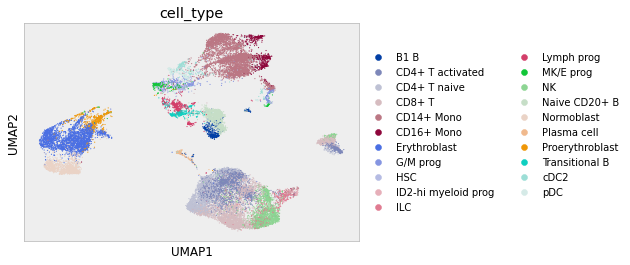

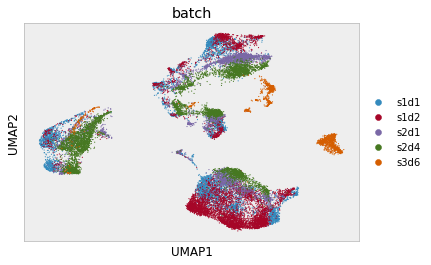

In [31]:
sc.pl.umap(
    adata_gex,
    color = ["cell_type"],
    #frameon = False,
)
sc.pl.umap(
    adata_gex,
    color = ["batch"],
    #frameon = False,
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">3.2 UMAP with Batch Correction</h1></span>

Using the LDVAE latent space to generate the same UMAP plots to see if scVI successfully accounts for batch effects in the data.

In [32]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata_gex, use_rep = "X_scVI")
sc.tl.umap(adata_gex, min_dist = 0.3)

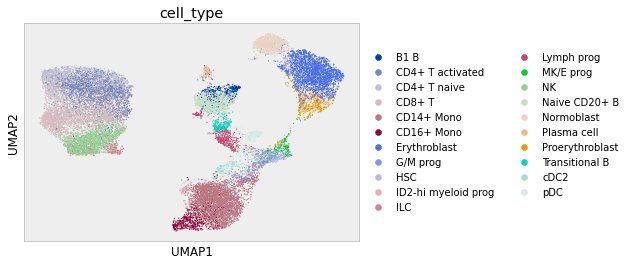

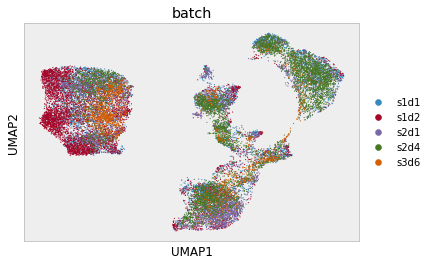

In [33]:
sc.pl.umap(
    adata_gex,
    color = ["cell_type"],
    #frameon=False,
)
sc.pl.umap(
    adata_gex,
    color = ["batch"],
    #frameon=False,
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">3.3 Clustering on the LDVAE Latent Space</h1></span>


It's easy to cluster the data with scanpy from LDVAE's latent space and then reinject them into scVI (e.g., for **differential expression**)

In [34]:
# Neighbors were already computed using scVI
sc.tl.leiden(adata_gex, key_added = "leiden_scVI", resolution = 0.5)

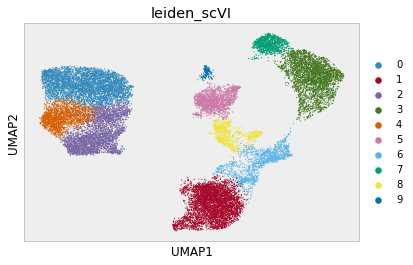

In [35]:
sc.pl.umap(
    adata_gex,
    color = ["leiden_scVI"],
    #frameon = False
)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4. Differential EXpression</h1></span>

We can also use many scvi-tools models for differential expression. 

In [36]:
adata_gex.obs.cell_type.head()

TAGTTGTCACCCTCAC-1-s1d1    Naive CD20+ B
CTATGGCCATAACGGG-1-s1d1       CD14+ Mono
CCGCACACAGGTTAAA-1-s1d1           CD8+ T
TCATTTGGTAATGGAA-1-s1d1           CD8+ T
ACCACATAGGTGTCCA-1-s1d1       CD16+ Mono
Name: cell_type, dtype: category
Categories (21, object): ['B1 B', 'CD4+ T activated', 'CD4+ T naive', 'CD8+ T', ..., 'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

We can also do a 1-vs-all DE test, which compares each cell type with the rest of the dataset:

In [37]:
de_df = model.differential_expression(
    groupby = "cell_type"
)
de_df.head()

/opt/conda/lib/python3.7/site-packages/scvi/model/base/_base_model.py:151: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  "Make sure the registered X field in anndata contains unnormalized count data."


DE...: 100%|██████████| 21/21 [02:12<00:00,  6.30s/it]


proba_de  proba_not_de  bayes_factor    scale1    scale2  \
COL4A4        0.9902        0.0098      4.615524  0.000743  0.000054   
SLC38A11      0.9894        0.0106      4.536244  0.000171  0.000037   
LARGE1        0.9890        0.0110      4.498798  0.003482  0.000342   
COL19A1       0.9888        0.0112      4.480577  0.003338  0.000653   
AL078459.1    0.9886        0.0114      4.462676  0.000980  0.000109   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  \
COL4A4               0.0   0.25  5.173760    5.222890  2.421283  ...   
SLC38A11             0.0   0.25  4.918445    5.156536  2.818283  ...   
LARGE1               0.0   0.25  5.321021    5.417674  2.631597  ...   
COL19A1              0.0   0.25  5.459781    5.719831  2.940087  ...   
AL078459.1           0.0   0.25  4.202911    4.191606  2.144336  ...   

            raw_mean1  raw_mean2  non_zeros_proportion1  \
COL4A4       0.782607   0.017543               0.348780   
SLC38A11     0.036223   0.024198               0.012195   
LARGE1       1.448318   0.176210               0.441463   
COL19A1      0.917309   0.369265               0.346341   
AL078459.1   0.596196   0.047400               0.212195   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
COL4A4                   0.010792             18.060129              0.346057   
SLC38A11                 0.007845              0.783445              0.464243   
LARGE1                   0.050515             33.542554              3.520655   
COL19A1                  0.067428             21.149084              7.206645   
AL078459.1               0.021267             13.479335              1.003656   

            is_de_fdr_0.05    comparison  group1 group2  
COL4A4                True  B1 B vs Rest    B1 B   Rest  
SLC38A11              True  B1 B vs Rest    B1 B   Rest  
LARGE1                True  B1 B vs Rest    B1 B   Rest  
COL19A1               True  B1 B vs Rest    B1 B   Rest  
AL078459.1            True  B1 B vs Rest    B1 B   Rest  

[5 rows x 22 columns]

We now extract top markers for each cluster using the DE results

In [38]:
markers = {}
cats = adata_gex.obs.cell_type.cat.categories

for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    
    cell_type_df = cell_type_df[cell_type_df.lfc_mean > 0]
    
    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    
    markers[c] = cell_type_df.index.tolist()[:3]

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4.1 Visualize a simple dendrogram</h1></span>

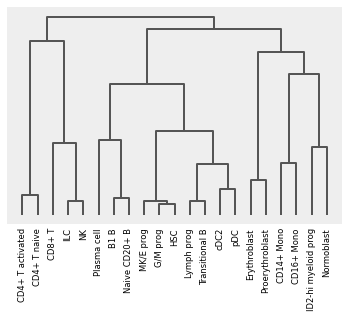

In [39]:
sc.tl.dendrogram(
    adata_gex, 
    groupby = "cell_type", 
    use_rep = "X_scVI"
)

ax = sc.pl.dendrogram(
    adata_gex,
    "cell_type"
    
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4.2 Visualize marker genes using dotplot</h1></span>

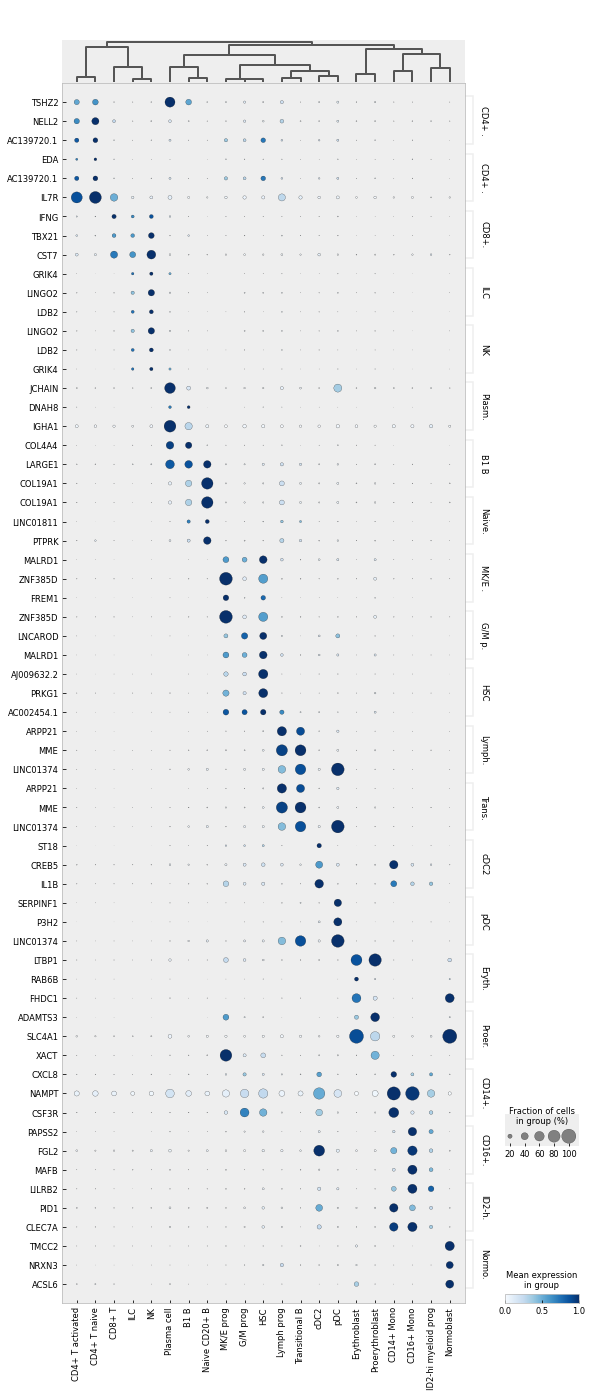

In [40]:
sc.pl.dotplot(
    adata_gex,
    markers,
    groupby = "cell_type",
    dendrogram = True,
    color_map = "Blues",
    swap_axes = True,
    use_raw = True,
    standard_scale = "var",
    save = "scRNA-seq_dotplot.pdf"
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4.3 Visualize marker genes using a heatmap</h1></span>
We can also visualize the scVI normalized gene expression values with the `layer` option

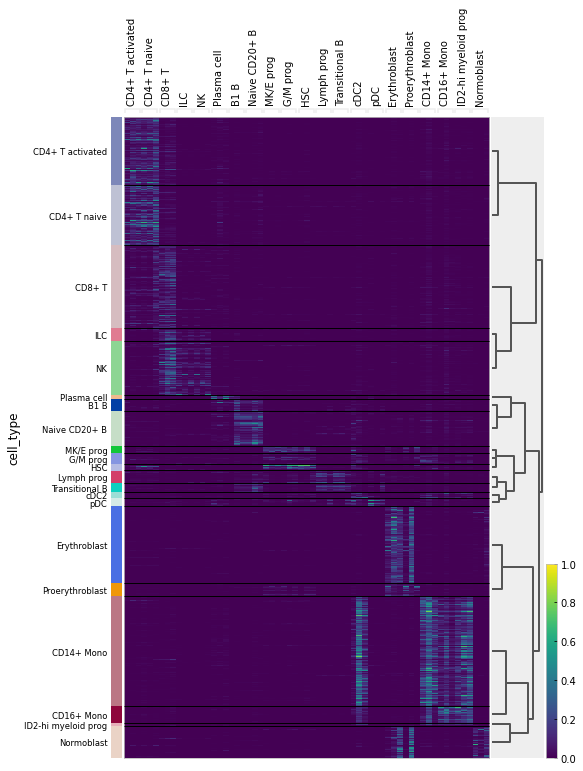

In [41]:
sc.pl.heatmap(
    adata_gex,
    markers,
    groupby = "cell_type",
    layer = "scvi_normalized",
    standard_scale = "var",
    dendrogram = True,
    figsize = (8, 12),
    save = "scRNA-seq_heatmap.pdf"
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4.4 Visualize marker genes using tracksplot "cell_type"</h1></span>

/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

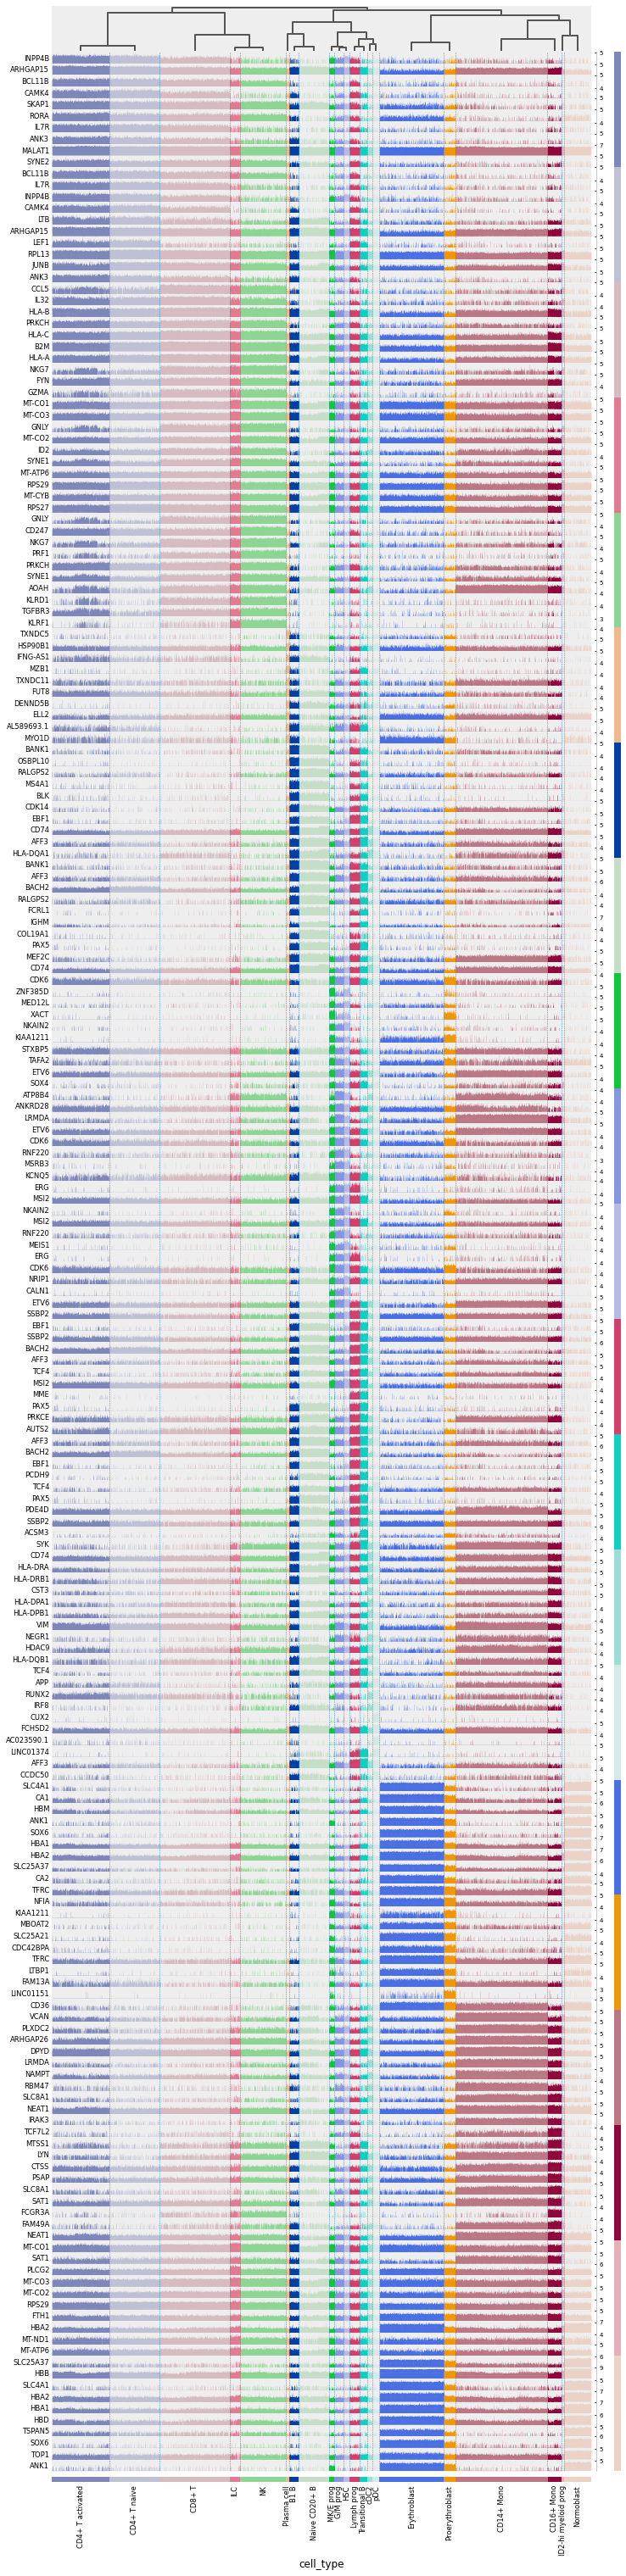

In [42]:
sc.tl.rank_genes_groups(
    adata_gex, 
    groupby = "cell_type", 
    use_raw = True, 
    method = "wilcoxon", 
    n_genes = 10
)

sc.pl.rank_genes_groups_tracksplot(
    adata_gex, 
    groupby = "cell_type"
)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">4.5 Visualize marker genes using tracksplot "leiden_scVI"</h1></span>

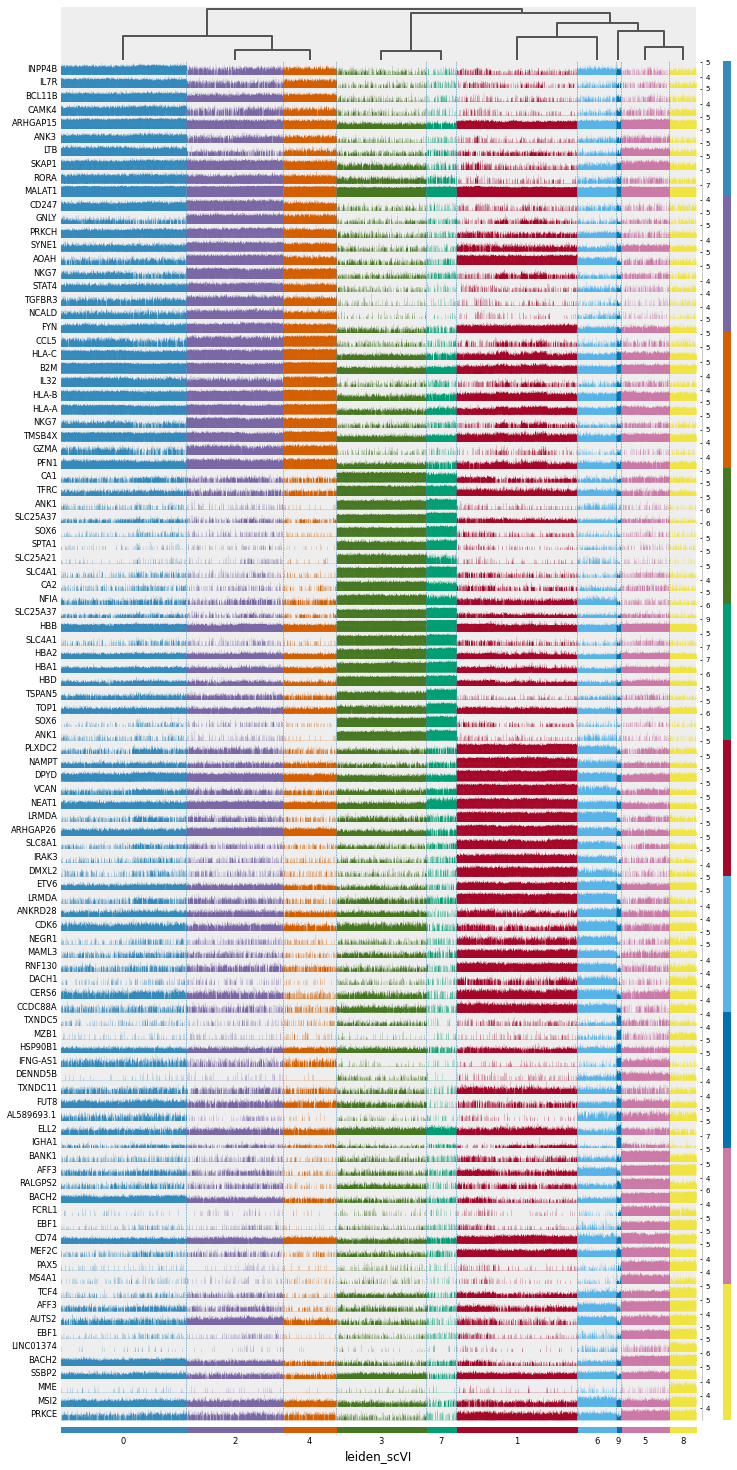

In [43]:
sc.tl.rank_genes_groups(
    adata_gex, 
    groupby = "leiden_scVI", 
    use_raw = True, 
    method = "wilcoxon", 
    n_genes = 10) # compute differential expression

sc.pl.rank_genes_groups_tracksplot(
    adata_gex, 
    groupby = "leiden_scVI"
)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">5. References</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">5.1 Papers</h1></span>

- Gayoso, A., Lopez, R., Xing, G., Boyeau, P., Wu, K., Jayasuriya, M., ... & Yosef, N. (2021). scvi-tools: a library for deep probabilistic analysis of single-cell omics data. bioRxiv.
- Wolf, F. A., Angerer, P., & Theis, F. J. (2018). SCANPY: large-scale single-cell gene expression data analysis. Genome biology, 19(1), 1-5.
- Svensson, V., Gayoso, A., Yosef, N., & Pachter, L. (2020). Interpretable factor models of single-cell RNA-seq via variational autoencoders. Bioinformatics, 36(11), 3418-3421.

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">5.2 Documentation</h1></span>

- **[scvi-tools](https://scvi-tools.org/)**
- **[Scanpy](https://scanpy.readthedocs.io/en/stable/)**

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #B3E5FC; color :  #0277BD; border-radius: 100px 100px; text-align:center">5.3 Notebooks</h1></span>
- [5 -Differential expression in Single cell RNA-seq](https://www.kaggle.com/aayush9753/5-differential-expression-in-single-cell-rna-seq)
- [scRNA-seq 🧬: Scanpy & SCMER for Feature Selection](https://www.kaggle.com/hiramcho/scrna-seq-scanpy-scmer-for-feature-selection)